# Análise de similaridade de imagens

O presente notebook tem o objetivo de resolver o desafio final do curso de Machine Learning - Criando um Sistema de Recomendação por similaridade de Imagens Digitais. O objetivo é coletar da internet uma imagem de produto e devolver quatro itens semelhantes que estão cadastrados em um catálogo.


As imagens e características dos objetos do catálogo de referência foram obtidas através do Kaggle:
https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small e possui 44424 imagens de produtos pertencentes a 143 classes distintas.

Utilizaremos o Big Transfer (BiT - https://tfhub.dev/google/bit/m-r50x3/1) para realizar a análise de similaridade das imagens. Conforme seu overview: "Big Transfer (BiT) is a recipe for pre-training image classification models on large supervised datasets and efficiently fine-tuning them on any given target task. The recipe achieves excellent performance on a wide variety of tasks, even when using very few labeled examples from the target dataset."


O processo aqui consiste em três macro etapas: 

a) Fine Tuning do modelo Big Transfer (BiT) e extração de características

b) Teste do modelo localmente

c) Criação de uma API para utilizar o modelo


Abaixo listo algumas referências utilizadas como pesquisa para este trabalho:

https://colab.research.google.com/github/sparsh-ai/rec-tutorials/blob/master/_notebooks/2021-04-27-image-similarity-recommendations.ipynb#scrollTo=OQ2y7D2L3d6h - Notebook base para este trabalho
https://www.kaggle.com/models/google/bit/tensorFlow2/m-r50x3/1?tfhub-redirect=true - Referência ao modelo de classificação.
https://arxiv.org/pdf/1912.11370 - Artigo de publicação do Big Transfer


Classes existentes:
'Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts', 'Socks', 'Casual Shoes', 'Belts', 'Flip Flops', 'Handbags', 'Tops', 'Bra', 'Sandals', 'Shoe Accessories', 'Sweatshirts', 'Deodorant', 'Formal Shoes', 'Bracelet', 'Lipstick', 'Flats', 'Kurtas',  'Waistcoat', 'Sports Shoes', 'Shorts', 'Briefs', 'Sarees',  'Perfume and Body Mist', 'Heels', 'Sunglasses', 'Innerwear Vests',  'Pendant', 'Nail Polish', 'Laptop Bag', 'Scarves', 'Rain Jacket',  'Dresses', 'Night suits', 'Skirts', 'Wallets', 'Blazers', 'Ring',  'Kurta Sets', 'Clutches', 'Shrug', 'Backpacks', 'Caps', 'Trousers',  'Earrings', 'Camisoles', 'Boxers', 'Jewellery Set', 'Dupatta',  'Capris', 'Lip Gloss', 'Bath Robe', 'Mufflers', 'Tunics',  'Jackets', 'Trunk', 'Lounge Pants', 'Face Wash and Cleanser',  'Necklace and Chains', 'Duffel Bag', 'Sports Sandals',  'Foundation and Primer', 'Sweaters', 'Free Gifts', 'Trolley Bag', 'Tracksuits', 'Swimwear', 'Shoe Laces', 'Fragrance Gift Set', 'Bangle', 'Nightdress', 'Ties', 'Baby Dolls', 'Leggings', 'Highlighter and Blush', 'Travel Accessory', 'Kurtis', 'Mobile Pouch', 'Messenger Bag', 'Lip Care', 'Face Moisturisers', 'Compact', 'Eye Cream', 'Accessory Gift Set', 'Beauty Accessory', 'Jumpsuit', 'Kajal and Eyeliner', 'Water Bottle', 'Suspenders', 'Lip Liner', 'Robe', 'Salwar and Dupatta', 'Patiala', 'Stockings', 'Eyeshadow', 'Headband', 'Tights', 'Nail Essentials', 'Churidar', 'Lounge Tshirts', 'Face Scrub and Exfoliator', 'Lounge Shorts', 'Gloves', 'Mask and Peel', 'Wristbands', 'Tablet Sleeve', 'Ties and Cufflinks', 'Footballs', 'Stoles', 'Shapewear', 'Nehru Jackets', 'Salwar', 'Cufflinks', 'Jeggings', 'Hair Colour', 'Concealer', 'Rompers', 'Body Lotion', 'Sunscreen', 'Booties', 'Waist Pouch', 'Hair Accessory', 'Rucksacks', 'Basketballs', 'Lehenga Choli', 'Clothing Set', 'Mascara', 'Toner', 'Cushion Covers', 'Key chain', 'Makeup Remover', 'Lip Plumper', 'Umbrellas', 'Face Serum and Gel', 'Hat', 'Mens Grooming Kit', 'Rain Trousers', 'Body Wash and Scrub', 'Suits', 'Ipad'.


## a) Fine Tuning do modelo Big Transfer (BiT) e extração de características

In [30]:
import itertools
import os

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Numpy version", np.__version__)
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU está", "disponível" if tf.config.list_physical_devices('GPU') else "NÃO DISPONÍVEL")

Numpy version 1.23.0
TF version: 2.10.0
Hub version: 0.16.1
GPU está disponível


In [5]:
# Definição do diretório onde estão as imagens e o arquivo com informações sobre as classes e outras características 

data_dir = 'C:/Users/mavga/Downloads/archive/'
print(f"Arquivo com detalhes dos itens do catálogo: {data_dir + 'styles.csv'}")

Arquivo com detalhes dos itens do catálogo: C:/Users/mavga/Downloads/archive/styles.csv


In [2]:
# Definição de hiperparâmetros do modelo

MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Utilizando {} com o seguinte tamanho de entrada {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32 
N_FEATURES = 256

Utilizando https://tfhub.dev/google/bit/m-r50x3/1 com o seguinte tamanho de entrada (224, 224)


In [10]:
# Transformando a estrutura de diretórios para utilizarmos os métodos de preprocessamento de imagens
# as imagens foram obtidas em https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small

import pandas as pd

img_desc = pd.read_csv(data_dir + 'styles.csv', sep=',', engine='python', on_bad_lines='skip')

img_desc['articleType_class'] = img_desc['articleType'].str.replace(" ", "_")
img_desc['filename'] = img_desc['id'].astype(str) + '.JPG'

print(f'O catálogo possui {len(img_desc)} imagens de produtos pertencentes a {len(img_desc["articleType"].unique())} classes.')

O catálogo possui 44424 imagens de produtos pertencentes a 143 classes.


In [19]:
# Criação de um dicionário cuja chave é o nome do arquivo e o valor é a classe à qual ele pertence. 
# Será utilizado para criar a estrutura de diretórios e redistribuir os arquivos
classes_arquivos = {row['filename']: row['articleType_class'] for idx, row in img_desc[['articleType_class', 'filename']].iterrows()}

first_item = list(classes_arquivos.items())[0]
print(f"Exemplo: {first_item}")

Exemplo: ('15970.JPG', 'Shirts')


In [20]:
# Função utilizada para criar um diretório para cada classe do catálogo assim como mover os arquivos de imagens para 
# seu respectivo diretório conforme classe declarada no arquivo styles.csv.

import os
import shutil

def organizar_imagens_por_classe(path, class_dict):
    if not os.path.isdir(path):
        raise NotADirectoryError(f"O caminho '{path}' não é um diretório válido.")
    
    destino_base = os.path.join(path, "img_org")
    os.makedirs(destino_base, exist_ok=True)

    for nome_arquivo, classe in class_dict.items():
        # Cria subdiretório da classe
        destino_classe = os.path.join(destino_base, classe)
        os.makedirs(destino_classe, exist_ok=True)

        # Caminho original do arquivo
        origem = os.path.join(path, nome_arquivo)

        # Verifica se o arquivo existe
        if not os.path.isfile(origem):
            print(f"Aviso: arquivo '{nome_arquivo}' não encontrado em '{path}'. Ignorado.")
            continue

        # Caminho final
        destino = os.path.join(destino_classe, nome_arquivo)
        shutil.move(origem, destino)
        print(f"Movido: {nome_arquivo} → {destino_classe}")


organizar_imagens_por_classe(data_dir + "/images/", classes_arquivos)

Movido: 15970.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Shirts
Movido: 39386.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Jeans
Movido: 59263.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Watches
Movido: 21379.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Track_Pants
Movido: 53759.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Tshirts
Movido: 1855.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Tshirts
Movido: 30805.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Shirts
Movido: 26960.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Shirts
Movido: 29114.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Socks
Movido: 30039.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Watches
Movido: 9204.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Casual_Shoes
Movido: 48123.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Belts
Movido: 18653.JPG → C:/Users/mavga/Downloads/archive//images/img_org\Flip_Flop

In [8]:
# Definição dos parâmetros para o preprocessamento das imagens

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

# Utilização da utility class ImageDataGenerator para coleta das imagens de validação na hierarquia de diretórios
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir + "/images/img_org/", subset="validation", shuffle=False, **dataflow_kwargs)


# Utilização da utility class ImageDataGenerator para coleta das imagens de treinamento na hierarquia de diretórios
# Opção para realizar a augmentation das imagens de treinamento
do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir + "/images/img_org/", subset="training", shuffle=True, **dataflow_kwargs)

Found 8825 images belonging to 143 classes.
Found 35594 images belonging to 143 classes.


In [9]:
# Definição do modelo
# Utilizando o tensorflow_hub, o modelo de imagem pré-treinado é adicionado logo após a camada de entrada da rede,
# adicionando então duas camadas: a primeira gerando um vetor de N_FEATURES características e a segunda para classificação.
# Treinaremos apenas essas duas últimas camadas com o catálogo e, após o treinamento, selecionaremos a camada de vetor de características 
# como saída do nosso codificador ajustado. Após o ajuste fino do modelo, salvaremos o extrator de características para uso na análise 
# de similaridade.

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # camada de entrada
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    # utilização do modelo BiT
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    
    tf.keras.layers.Dropout(rate=0.2),
    
    # camada de geração do vetor de características
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    
    tf.keras.layers.Dropout(rate=0.2),
    # camada de classificação
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 143)               36751     
                                                                 
Total params: 212,783,951
Trainable params: 1,609,871
Non-trainable params: 211,174,080
_________________________________________

In [12]:
# Definição de hiperparâmetros do modelo, das funções de otimização e perda
# Compilação do modelo

lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Diminui o learning rate por um fator de 10 na SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
# função de otimização
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# função de perda
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# compilação do modelo
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [13]:
# Treinamento do modelo com apenas 3 épocas

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/3
1112/1112 [==============================] - 744s 661ms/step - loss: 1.8875 - accuracy: 0.6627 - val_loss: 1.1554 - val_accuracy: 0.7580
Epoch 2/3
1112/1112 [==============================] - 739s 665ms/step - loss: 1.5944 - accuracy: 0.6962 - val_loss: 1.1535 - val_accuracy: 0.7583
Epoch 3/3
1112/1112 [==============================] - 740s 665ms/step - loss: 1.5927 - accuracy: 0.6971 - val_loss: 1.1518 - val_accuracy: 0.7586


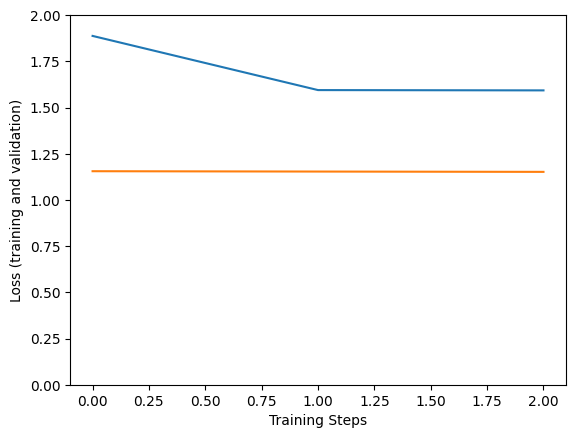

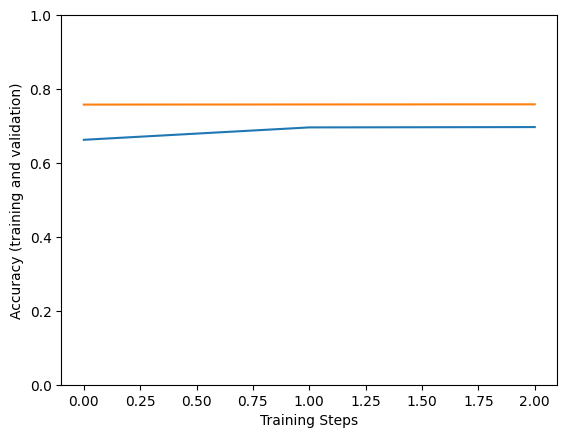

In [15]:
# Apresentação da perda e acurácia para o treinamento

#hide
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
# Definição do diretório do projeto para salvamento 
proj_path = 'C:/Users/mavga/BairesDev_MLearning/analise_similaridade/'

if not os.path.exists(proj_path):
    os.mkdir(proj_path)


# Salvamento dos pesos do modelo para eventual uso futuro.
model.save_weights(proj_path + "/pesos_fashion_images.weights")

# Salvamento de um modelo com base no modelo recém treinado, chegando até a antepenúltima camada
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save(proj_path +'/bit_feature_extractor', save_format='tf')

saved_model_path = proj_path + '/bit_model'
tf.saved_model.save(model, saved_model_path)

## b) Teste do modelo localmente

In [32]:
#importa os pacotes necessários
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
# from tqdm import tqdm
# tqdm.pandas()

In [17]:
# Cria uma lista com os arquivos JPG na estrutura do catálogo

img_paths = []
for path in Path('C:/Users/mavga/Downloads/archive/images/img_org/').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [18]:
img_paths

[WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Caps/19741.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Handbags/37005.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Flip_Flops/35573.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Watches/18525.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Heels/41470.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Tshirts/52150.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Heels/59760.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Shirts/9254.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Sports_Shoes/3242.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Shirts/13854.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Flip_Flops/39547.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Tshirts/4032.JPG'),
 Win

In [25]:
# Função para retornar a imagem em formato tensor
# realiza o preprocessamento da imagem, convertendo para RGB, redimensionando para (224,224), convertendo para tensor 
# e adicionando uma nova coluna no início

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [23]:
#Carrega o modelo previamente treinado caso o TRANSFER_LEARNING_FLAG seja = 1
proj_path = 'C:/Users/mavga/BairesDev_MLearning/analise_similaridade/'
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model(proj_path + '/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1" 
  module = hub.load(module_handle)

In [24]:
# Cria um diretório para as imagens vetorizadas
imgvec_path = data_dir + '/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [25]:
img_paths[:5000]

[WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Caps/19741.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Handbags/37005.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Flip_Flops/35573.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Watches/18525.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Heels/41470.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Tshirts/52150.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Heels/59760.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Shirts/9254.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Sports_Shoes/3242.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Shirts/13854.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Flip_Flops/39547.JPG'),
 WindowsPath('C:/Users/mavga/Downloads/archive/images/img_org/Tshirts/4032.JPG'),
 Win

In [29]:
# Carrega as 5000 primeiras imagens da lista img_paths
# utiliza o modelo salvo para extrair as características de cada imagem e ajusta a dimensionalidade
# salva as características em formato npz para cada imagem

for filename in img_paths[:5000]:
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

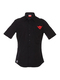

In [35]:
# importa pacotes úteis, inclui o indice Annoy (Approximate Nearest Neighbors) para análise da similaridade
import pandas as pd
import glob
import os
import numpy as np

# !pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

# exemplo do uso do objeto Image do IPython.display
test_img = 'C:/Users/mavga/Downloads/archive/images/img_org/Shirts/3616.JPG'
dispImage(test_img)

In [40]:
#Salva o ID como string
styles = pd.read_csv(data_dir + 'styles.csv', sep=',', engine='python', on_bad_lines='skip')

styles['id'] = styles['id'].astype('str')
styles.to_csv(data_dir + '/styles.csv', index=False)

In [38]:
# Define a função para retornar o indice do dataframe filtranso pelo ID
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [36]:
# Define os dicionários com indices das imagens para facilitar o restante do processo e cria o índice

# Indices com nome dos arquivos
file_index_to_file_name = {}
# Indices com vetores das características
file_index_to_file_vector = {}
# Indices com o id de produto relacionando com os metadados dos produtos
file_index_to_product_id = {}

# Configurando os parâmetros do índice Annoy
dims = 256
n_nearest_neighbors = 20
trees = 10000

# lista os nomes de arquivos com vetores de características 
allfiles = glob.glob('C:/Users/mavga/Downloads/archive/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [42]:
# Abre cada arquivo com o vetor de características das imagens e preenche os dicionários criados na célula anterior
for findex, fname in enumerate(allfiles):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass 
  t.add_item(findex, file_vector)

In [43]:
#Constroi o indice Annoy e o salva
t.build(trees)
t.save('t.ann')

True

In [44]:
#serializa os dicionários  para uso posterior através do pickle
file_path = 'C:/Users/mavga/Downloads/archive/img_vectors/'
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

In [27]:
# Importa a biblioteca PIL e objetos necessários
from PIL import Image
import matplotlib.image as mpimg
import PIL
print("PIL Version: ", PIL.__version__)

PIL Version:  11.1.0


File downloaded successfully.


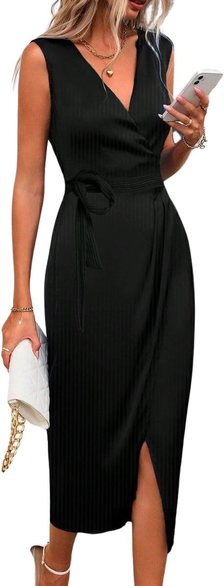

In [46]:
# Executa o teste do modelo na análise de similaridade de imagens. Aqui o processo consiste em obter uma imagem da internet, 
# transformar a iamgem em um vetor


import requests


# img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'
img_addr = 'https://m.media-amazon.com/images/I/51oXdd-fy0L._AC_SX679_.jpg'

# !wget -q -O img.jpg $img_addr
# test_img = 'img.jpg'

# obtem a imagem através da biblioteca requests e a salva localmente
response = requests.get(img_addr)

if response.status_code == 200:
    with open('img.jpg', 'wb') as f:
        f.write(response.content)
    print("O arquivo foi adquirido com sucesso.")
else:
    print(f"Falha ao obter o arquivo. Status: {response.status_code}")



test_img = 'img.jpg'
# apenas os 4 mais similares
topK = 4

# carrega a imagem como vetor
test_vec = np.squeeze(module(load_img(test_img)))


basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

28708
52450
57996
57418


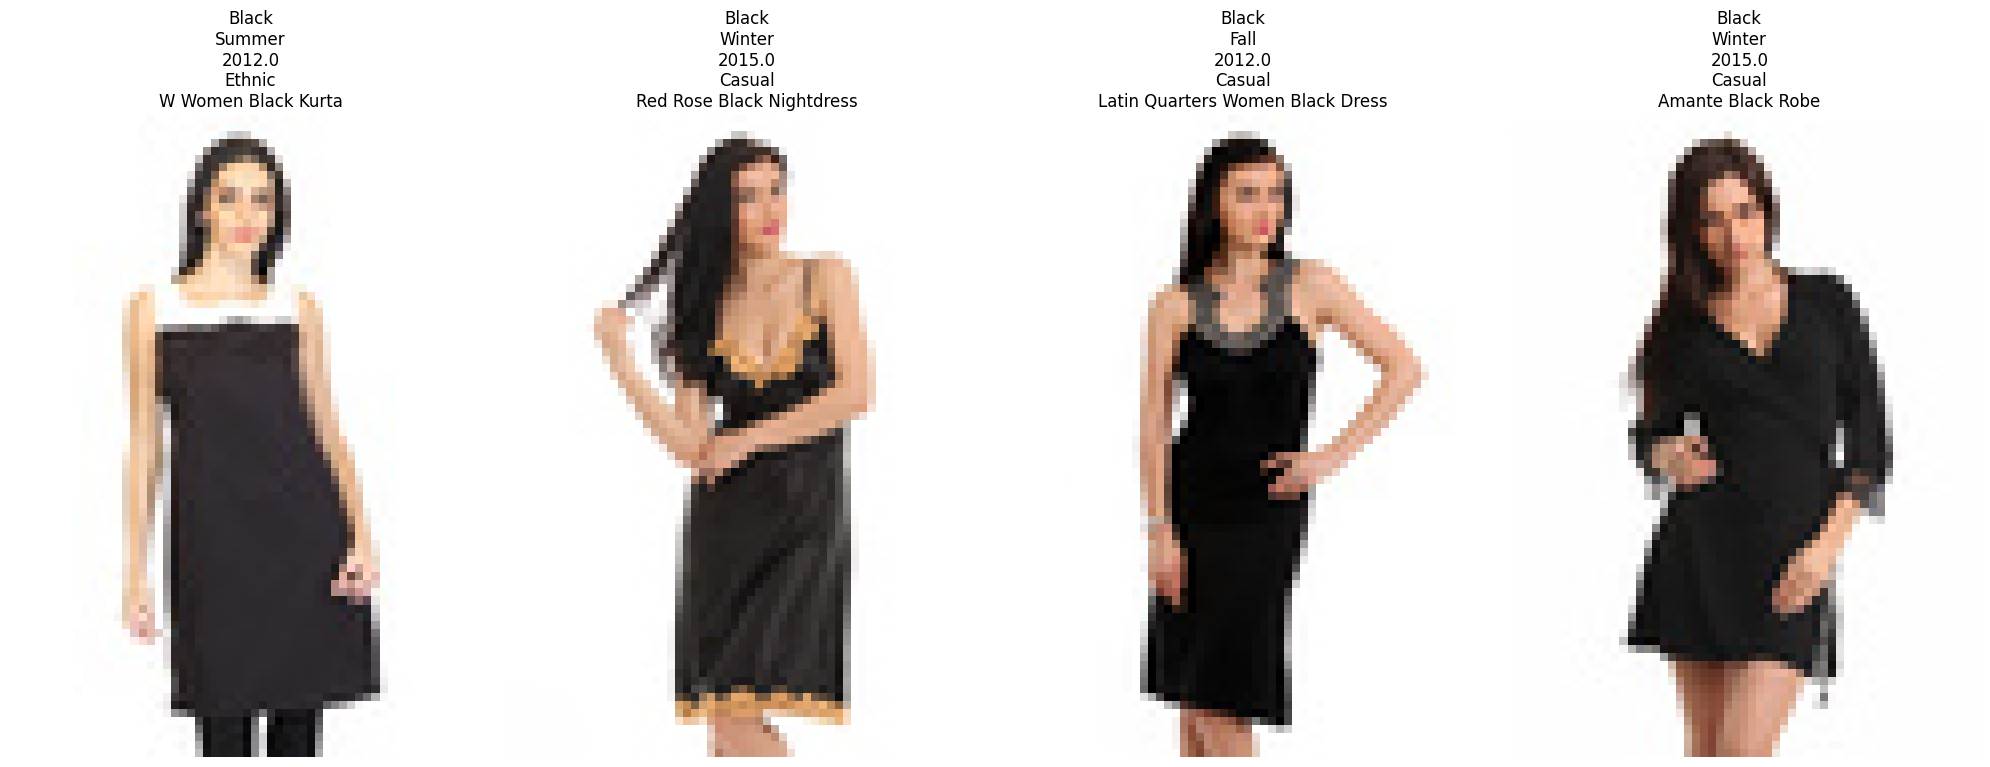

In [47]:

# Lista as imagens do diretório do catálogo
path_dict = {}
for path in Path('C:/Users/mavga/Downloads/archive/images/img_org/').rglob('*.jpg'):
  path_dict[path.name] = path


nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
#
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  print(x)
  x = path_dict[x + '.JPG']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()